In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

In [3]:
class MLP(nn.Module):
    def __init__(self, hidden_layers, neurons_per_layer):
        super(MLP, self).__init__()

        self.input_layer = nn.Linear(4, neurons_per_layer)  # 4 inputs: t, U0, W0, K
        self.hidden_layers = nn.ModuleList(
            [nn.Linear(neurons_per_layer, neurons_per_layer) for _ in range(hidden_layers)])
        self.output_layer = nn.Linear(neurons_per_layer, 2)  # 2 outputs: U, W

        self.activation = nn.Tanh()

    def forward(self, x):
        x = self.activation(self.input_layer(x))
        for layer in self.hidden_layers:
            x = self.activation(layer(x))
        return self.output_layer(x)

MLP_model = MLP(hidden_layers=4, neurons_per_layer=64)
optimizer = optim.Adam(MLP_model.parameters(), lr=1e-3,weight_decay=0.01)

In [4]:
def Physic_Loss (t_current, U0_current, W0_current, K_current,U_pred, W_pred):
    # Physics-informed loss
    dU_dt = torch.autograd.grad(U_pred, t_current, grad_outputs=torch.ones_like(U_pred), create_graph=True)[0]
    dW_dt = torch.autograd.grad(W_pred, t_current, grad_outputs=torch.ones_like(W_pred), create_graph=True)[0]

    fhn_U, fhn_W = fhn_equations(U0_current, W0_current, K_current)

    mse_U = torch.mean((dU_dt - fhn_U) ** 2)
    mse_W = torch.mean((dW_dt - fhn_W) ** 2)
    return mse_U + mse_W

In [5]:
def intial_condition(U_true, W_true,U_pred, W_pred):
    mse_U = torch.mean((U_pred - U_true) ** 2)
    mse_W = torch.mean((W_pred - W_true) ** 2)
    return mse_U + mse_W

In [6]:
def Data_Loss (U_pred, W_pred,U_true, W_true):
    # Data-informed loss
    mse_U = torch.mean((U_pred - U_true) ** 2)
    mse_W = torch.mean((W_pred - W_true) ** 2)
    return mse_U + mse_W

In [7]:
def fhn_equations(U, W, K):
  dU_dt = K * U * (U - 0.4) * (1 - U) - W
  dW_dt = 0.5 * (0.2 * U - 0.8 * W)
  return dU_dt, dW_dt

In [8]:
def euler_solver(u0, w0, K, t_max, dt):
    """Solve FHN model using Euler method"""
    t = np.arange(0, t_max, dt)
    u = np.zeros_like(t)
    w = np.zeros_like(t)
    u[0], w[0] = u0, w0
    for i in range(1, len(t)):
        du_dt, dw_dt = fhn_equations(u[i - 1], w[i - 1], K)
        u[i] = u[i - 1] + du_dt * dt
        w[i] = w[i - 1] + dw_dt * dt
    return t, u, w

In [9]:
def generate_fhn_data(num_samples,seed=None):
    """Generate data for different initial conditions and K values"""
    data = []
    t_max = 100
    dt = 0.01
    if seed is not None:
        np.random.seed(seed)  # Set the random seed for reproducibility
    for i in range((num_samples)):
      u0 = np.random.uniform(.4,0.6)  # Random number from 0 to 0.6
      w0 = np.random.uniform(0,.2)   # Random number from 0 to 0.6
      K = np.random.uniform(2,2.7) 
      t, u, w = euler_solver(u0, w0, K, t_max, dt)
      data.append({'t': t,'u0': u0, 'w0': w0, 'K': K, 'u': u, 'w': w})
    return data

In [ ]:
from sklearn.model_selection import train_test_split

# Assuming `data` is your complete dataset
training_data, validation_data = train_test_split(generate_fhn_data(num_samples=5000,seed=42), test_size=0.75, random_state=42)
test_data, validation_data = train_test_split(validation_data, test_size=0.5, random_state=42)

In [ ]:
# Randomly select four samples to plot from training data 
num_samples = len(training_data)
random_indices = np.random.choice(num_samples, size=4, replace=False)

# Create a figure with 4 subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 10))  # 2 rows, 2 columns

# Flatten the array of axes for easy iteration
axs = axs.flatten()

# Loop through the randomly selected samples and plot their u and w values
for i, idx in enumerate(random_indices):
    axs[i].plot(training_data[idx]['t'], training_data[idx]['u'], label='u', color='blue')
    axs[i].plot(training_data[idx]['t'], training_data[idx]['w'], label='w', color='orange', linestyle='dotted')
    
    # Set labels and title for each subplot
    axs[i].set_xlabel('Time')
    axs[i].set_ylabel('Value')
    axs[i].set_title(f"FHN Model Trainig Sample: u0={training_data[idx]['u0']:.2f}, w0={training_data[idx]['w0']:.2f}, K={training_data[idx]['K']:.2f}")
    axs[i].legend()
    axs[i].grid()

plt.tight_layout()
plt.show()

In [ ]:
# plot the sample closest to the one in the papaer Define tolerance for closeness
tolerance_u0 = 0.3  # Tolerance for u0
tolerance_w0 = 0.3  # Tolerance for w0
tolerance_K = 0.3

# Find the first sample that meets the criteria within the defined tolerance
sample_to_plot = next((sample for sample in training_data 
                       if abs(sample['u0'] - 0.6) < tolerance_u0 and 
                          abs(sample['w0'] - 0) < tolerance_w0 and 
                          abs(sample['K'] - 2.3) < tolerance_w0), 
                      None)

# Check if a valid sample was found
if sample_to_plot is not None:
    fig, ax1 = plt.subplots(figsize=(10, 5))
    ax1.plot(sample_to_plot['t'], sample_to_plot['u'], label='u')
    ax1.plot(sample_to_plot['t'], sample_to_plot['w'], label='w')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Value')  # Corrected line
    ax1.legend()
    ax1.set_title(f"FHN Model: u0={sample_to_plot['u0']:.2f}, w0={sample_to_plot['w0']:.2f}, K={sample_to_plot['K']:.2f}")
    plt.tight_layout()
    plt.show()
else:
    print("No sample found close to u0=0.6 and w0=0.")

In [ ]:
#helper method to transform generated data to tensors and return it as batches
def Transform_to_Tensors (Data,batch_size):
    t = torch.FloatTensor(Data[0]['t']).reshape(-1, 1).requires_grad_(True)
    U0 = torch.FloatTensor([Data[0]['u0']]).reshape(-1, 1) #Single value
    W0 = torch.FloatTensor([Data[0]['w0']]).reshape(-1, 1)
    K = torch.FloatTensor([Data[0]['K']]).reshape(-1, 1)
    U_true = torch.FloatTensor(Data[0]['u']).reshape(-1, 1)
    W_true = torch.FloatTensor(Data[0]['w']).reshape(-1, 1)
    # Create a TensorDataset
    dataset = TensorDataset(t, U0.expand_as(t), W0.expand_as(t), K.expand_as(t), U_true, W_true)

    # Create DataLoader for batching
    batch_size = 1000  # You can adjust this value
    data_loader= DataLoader(dataset, batch_size=batch_size, shuffle=False)
    return data_loader

In [ ]:
training_data = Transform_to_Tensors(training_data,32)

In [ ]:
validation_data = Transform_to_Tensors(validation_data,32)

In [ ]:
test_data = Transform_to_Tensors(test_data,32)

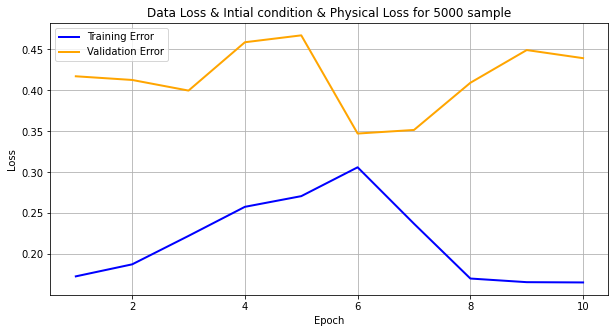

In [31]:
# Training loop
num_epochs = 10
gamma = 0.9999  # Learning rate decay factor

train_errors = []
val_errors = []
for epoch in range(num_epochs):
    sum_train_errors=0
    
    sum_val_errors=0
    for batch in training_data:
        t_current, U0_current, W0_current, K_current, U_true_current, W_true_current = batch

        # Get predictions
        inputs_current = torch.cat([t_current, U0_current, W0_current, K_current], dim=1)
        U_pred, W_pred = MLP_model(inputs_current).split(1, dim=1)

        # Calculate Data loss for the current batch
        loss_D = Data_Loss(U_pred, W_pred,U_true_current, W_true_current)  
        Loss_B = intial_condition(U_true_current, W_true_current,U_pred, W_pred)
        loss_I = Physic_Loss(t_current, U0_current, W0_current, K_current,U_pred, W_pred)

        Total_Loss=loss_D+(2*Loss_B)+loss_I
        sum_train_errors += Total_Loss
        # Backpropagation
        optimizer.zero_grad()
        Total_Loss.backward()
        optimizer.step()
        
    train_errors.append(sum_train_errors)
    
    sum_val_error = 0
    #with torch.no_grad():
    for batch in validation_data:
        t_val, U0_val, W0_val, K_val, U_true_val, W_true_val = batch
            
        # Concatenate inputs for the model
        inputs_val = torch.cat([t_val, U0_val, W0_val, K_val], dim=1)

        # Get predictions
        U_pred_val, W_pred_val = MLP_model(inputs_val).split(1, dim=1)

        # Calculate Data loss for the validation batch
            
        loss_D = Data_Loss(U_pred_val, W_pred_val,U_true_val, W_true_val) 
        Loss_B = intial_condition(U_true_val, W_true_val,U_pred_val, W_pred_val)
        loss_I = Physic_Loss(t_val, U0_val, W0_val, K_val,U_pred_val, W_pred_val)        

        Total_Loss=loss_D+Loss_B+loss_I
        sum_val_errors+=Total_Loss # Store the loss
            
    
    val_errors.append(sum_val_errors)
    

# Plotting the loss against epochs
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1),train_errors, color='blue',label='Training Error', linewidth=2)
plt.plot(range(1, num_epochs + 1),val_errors,color='orange',label='Validation Error', linewidth=2)
plt.title('Data Loss & Intial condition & Physical Loss for 5000 sample')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()  # Add this line to show the legend
plt.grid()
plt.show()

Average Training Loss: 2.15733433 , Average Validation Loss: 4.15188646
Average Test Loss: 0.31881085


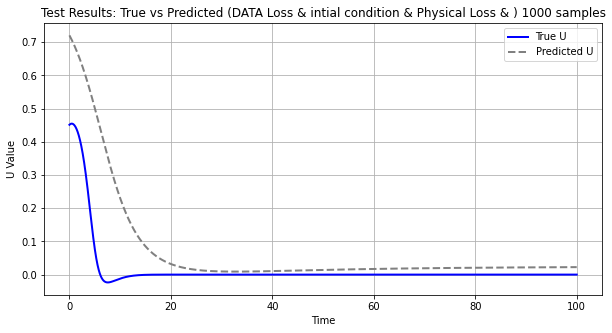

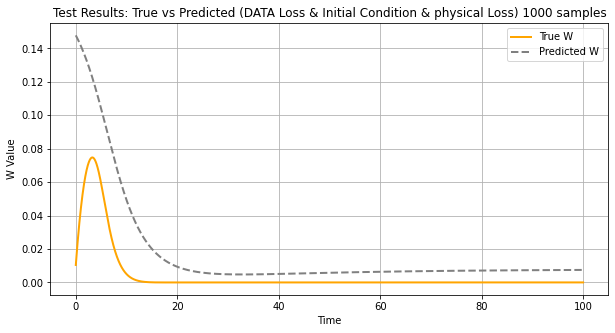

In [32]:
# Plot 
predictions_u = []
predictions_w = []
true_u = []
true_w  = []
Time = []

sum_test_errors=0
for batch in test_data:

    t, U0, W0, K, U_true, W_true = batch
    print("U0"{U0})

        # Get predictions
    inputs_current = torch.cat([t, U0, W0, K], dim=1)
    U_pred, W_pred = MLP_model(inputs_current).split(1, dim=1)

    # Calculate Data loss for the current batch
    loss_D = Data_Loss(U_pred, W_pred,U_true, W_true)  
    Loss_B = intial_condition(U_true, W_true,U_pred, W_pred)
    loss_I = Physic_Loss(t_val, U0_val, W0_val, K_val,U_pred_val, W_pred_val)        
    Total_Loss=loss_D+Loss_B+loss_I
    sum_test_errors += Total_Loss
    # Store predictions and true values for visualization
    predictions_u.append(U_pred.detach().numpy())
    true_u.append(U_true.detach().numpy())
    predictions_w.append(W_pred.detach().numpy())
    true_w.append(W_true.detach().numpy())
    Time.append(t.detach().numpy())

print(f"Average Training Loss: {sum(train_errors):.8f} , Average Validation Loss: {sum(val_errors):.8f}")
print(f"Average Test Loss: {sum_test_errors:.8f}")



predictions_u=np.concatenate(predictions_u, axis=0).squeeze()
true_u=np.concatenate(true_u, axis=0).squeeze()
predictions_w=np.concatenate(predictions_w, axis=0).squeeze()
true_w=np.concatenate(true_w, axis=0).squeeze()
Time = np.concatenate(Time,axis =0).squeeze()

    # Plotting the loss against epochs
plt.figure(figsize=(10, 5))
plt.plot(Time, true_u, label='True U', color='blue', linewidth=2)
plt.plot(Time, predictions_u, label='Predicted U', color='gray', linestyle='--', linewidth=2)
plt.title('Test Results: True vs Predicted (DATA Loss & intial condition & Physical Loss & ) 1000 samples')
plt.xlabel('Time')
plt.ylabel('U Value')
plt.legend()
plt.grid()

plt.figure(figsize=(10, 5))
plt.plot(Time, true_w, label='True W', color='orange', linewidth=2)
plt.plot(Time, predictions_w, label='Predicted W', color='gray', linestyle='--', linewidth=2)

plt.title('Test Results: True vs Predicted (DATA Loss & Initial Condition & physical Loss) 1000 samples')
plt.xlabel('Time')
plt.ylabel('W Value')
plt.legend()
plt.grid()

plt.show()

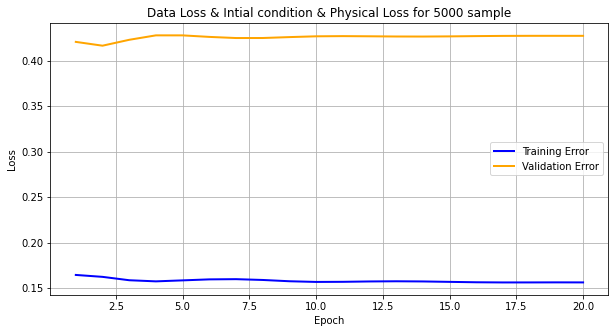

In [33]:
# Training loop
num_epochs = 20
gamma = 0.9999  # Learning rate decay factor

train_errors = []
val_errors = []
for epoch in range(num_epochs):
    sum_train_errors=0
    
    sum_val_errors=0
    for batch in training_data:
        t_current, U0_current, W0_current, K_current, U_true_current, W_true_current = batch

        # Get predictions
        inputs_current = torch.cat([t_current, U0_current, W0_current, K_current], dim=1)
        U_pred, W_pred = MLP_model(inputs_current).split(1, dim=1)

        # Calculate Data loss for the current batch
        loss_D = Data_Loss(U_pred, W_pred,U_true_current, W_true_current)  
        Loss_B = intial_condition(U_true_current, W_true_current,U_pred, W_pred)
        loss_I = Physic_Loss(t_current, U0_current, W0_current, K_current,U_pred, W_pred)

        Total_Loss=loss_D+(2*Loss_B)+loss_I
        sum_train_errors += Total_Loss
        # Backpropagation
        optimizer.zero_grad()
        Total_Loss.backward()
        optimizer.step()
        
    train_errors.append(sum_train_errors)
    
    sum_val_error = 0
    #with torch.no_grad():
    for batch in validation_data:
        t_val, U0_val, W0_val, K_val, U_true_val, W_true_val = batch
            
        # Concatenate inputs for the model
        inputs_val = torch.cat([t_val, U0_val, W0_val, K_val], dim=1)

        # Get predictions
        U_pred_val, W_pred_val = MLP_model(inputs_val).split(1, dim=1)

        # Calculate Data loss for the validation batch
            
        loss_D = Data_Loss(U_pred_val, W_pred_val,U_true_val, W_true_val) 
        Loss_B = intial_condition(U_true_val, W_true_val,U_pred_val, W_pred_val)
        loss_I = Physic_Loss(t_val, U0_val, W0_val, K_val,U_pred_val, W_pred_val)        

        Total_Loss=loss_D+Loss_B+loss_I
        sum_val_errors+=Total_Loss # Store the loss
            
    
    val_errors.append(sum_val_errors)
    

# Plotting the loss against epochs
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1),train_errors, color='blue',label='Training Error', linewidth=2)
plt.plot(range(1, num_epochs + 1),val_errors,color='orange',label='Validation Error', linewidth=2)
plt.title('Data Loss & Intial condition & Physical Loss for 5000 sample')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()  # Add this line to show the legend
plt.grid()
plt.show()

Average Training Loss: 3.16411853 , Average Validation Loss: 8.51597500
Average Test Loss: 0.30610821


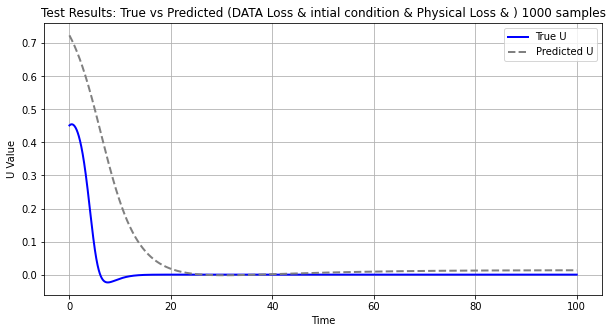

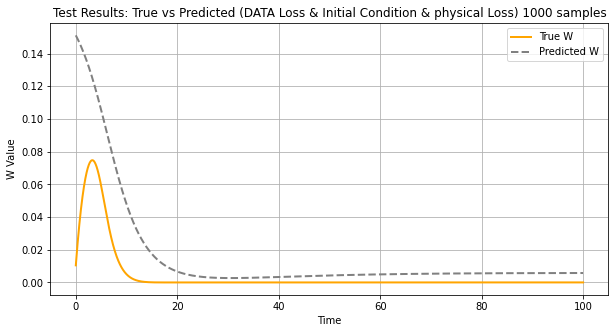

In [34]:
# Plot 
predictions_u = []
predictions_w = []
true_u = []
true_w  = []
Time = []

sum_test_errors=0
for batch in test_data:

    t, U0, W0, K, U_true, W_true = batch

        # Get predictions
    inputs_current = torch.cat([t, U0, W0, K], dim=1)
    U_pred, W_pred = MLP_model(inputs_current).split(1, dim=1)

    # Calculate Data loss for the current batch
    loss_D = Data_Loss(U_pred, W_pred,U_true, W_true)  
    Loss_B = intial_condition(U_true, W_true,U_pred, W_pred)
    loss_I = Physic_Loss(t_val, U0_val, W0_val, K_val,U_pred_val, W_pred_val)        
    Total_Loss=loss_D+Loss_B+loss_I
    sum_test_errors += Total_Loss
    # Store predictions and true values for visualization
    predictions_u.append(U_pred.detach().numpy())
    true_u.append(U_true.detach().numpy())
    predictions_w.append(W_pred.detach().numpy())
    true_w.append(W_true.detach().numpy())
    Time.append(t.detach().numpy())

print(f"Average Training Loss: {sum(train_errors):.8f} , Average Validation Loss: {sum(val_errors):.8f}")
print(f"Average Test Loss: {sum_test_errors:.8f}")



predictions_u=np.concatenate(predictions_u, axis=0).squeeze()
true_u=np.concatenate(true_u, axis=0).squeeze()
predictions_w=np.concatenate(predictions_w, axis=0).squeeze()
true_w=np.concatenate(true_w, axis=0).squeeze()
Time = np.concatenate(Time,axis =0).squeeze()

    # Plotting the loss against epochs
plt.figure(figsize=(10, 5))
plt.plot(Time, true_u, label='True U', color='blue', linewidth=2)
plt.plot(Time, predictions_u, label='Predicted U', color='gray', linestyle='--', linewidth=2)
plt.title('Test Results: True vs Predicted (DATA Loss & intial condition & Physical Loss & ) 1000 samples')
plt.xlabel('Time')
plt.ylabel('U Value')
plt.legend()
plt.grid()

plt.figure(figsize=(10, 5))
plt.plot(Time, true_w, label='True W', color='orange', linewidth=2)
plt.plot(Time, predictions_w, label='Predicted W', color='gray', linestyle='--', linewidth=2)

plt.title('Test Results: True vs Predicted (DATA Loss & Initial Condition & physical Loss) 1000 samples')
plt.xlabel('Time')
plt.ylabel('W Value')
plt.legend()
plt.grid()

plt.show()

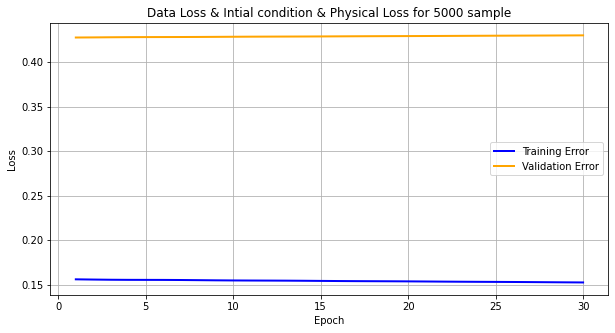

In [35]:
# Training loop
num_epochs = 30
gamma = 0.9999  # Learning rate decay factor

train_errors = []
val_errors = []
for epoch in range(num_epochs):
    sum_train_errors=0
    
    sum_val_errors=0
    for batch in training_data:
        t_current, U0_current, W0_current, K_current, U_true_current, W_true_current = batch

        # Get predictions
        inputs_current = torch.cat([t_current, U0_current, W0_current, K_current], dim=1)
        U_pred, W_pred = MLP_model(inputs_current).split(1, dim=1)

        # Calculate Data loss for the current batch
        loss_D = Data_Loss(U_pred, W_pred,U_true_current, W_true_current)  
        Loss_B = intial_condition(U_true_current, W_true_current,U_pred, W_pred)
        loss_I = Physic_Loss(t_current, U0_current, W0_current, K_current,U_pred, W_pred)

        Total_Loss=loss_D+(2*Loss_B)+loss_I
        sum_train_errors += Total_Loss
        # Backpropagation
        optimizer.zero_grad()
        Total_Loss.backward()
        optimizer.step()
        
    train_errors.append(sum_train_errors)
    
    sum_val_error = 0
    #with torch.no_grad():
    for batch in validation_data:
        t_val, U0_val, W0_val, K_val, U_true_val, W_true_val = batch
            
        # Concatenate inputs for the model
        inputs_val = torch.cat([t_val, U0_val, W0_val, K_val], dim=1)

        # Get predictions
        U_pred_val, W_pred_val = MLP_model(inputs_val).split(1, dim=1)

        # Calculate Data loss for the validation batch
            
        loss_D = Data_Loss(U_pred_val, W_pred_val,U_true_val, W_true_val) 
        Loss_B = intial_condition(U_true_val, W_true_val,U_pred_val, W_pred_val)
        loss_I = Physic_Loss(t_val, U0_val, W0_val, K_val,U_pred_val, W_pred_val)        

        Total_Loss=loss_D+Loss_B+loss_I
        sum_val_errors+=Total_Loss # Store the loss
            
    
    val_errors.append(sum_val_errors)
    

# Plotting the loss against epochs
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1),train_errors, color='blue',label='Training Error', linewidth=2)
plt.plot(range(1, num_epochs + 1),val_errors,color='orange',label='Validation Error', linewidth=2)
plt.title('Data Loss & Intial condition & Physical Loss for 5000 sample')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()  # Add this line to show the legend
plt.grid()
plt.show()

Average Training Loss: 4.63167572 , Average Validation Loss: 12.86149979
Average Test Loss: 0.30674624


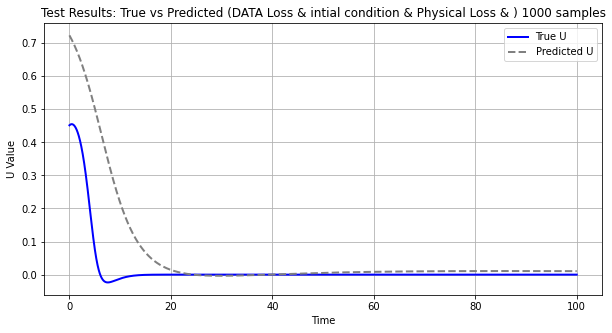

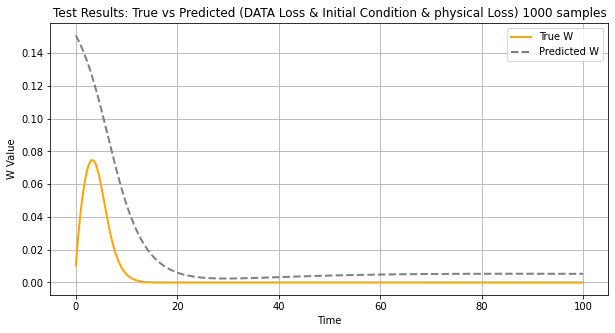

In [36]:
# Plot 
predictions_u = []
predictions_w = []
true_u = []
true_w  = []
Time = []

sum_test_errors=0
for batch in test_data:

    t, U0, W0, K, U_true, W_true = batch

        # Get predictions
    inputs_current = torch.cat([t, U0, W0, K], dim=1)
    U_pred, W_pred = MLP_model(inputs_current).split(1, dim=1)

    # Calculate Data loss for the current batch
    loss_D = Data_Loss(U_pred, W_pred,U_true, W_true)  
    Loss_B = intial_condition(U_true, W_true,U_pred, W_pred)
    loss_I = Physic_Loss(t_val, U0_val, W0_val, K_val,U_pred_val, W_pred_val)        
    Total_Loss=loss_D+Loss_B+loss_I
    sum_test_errors += Total_Loss
    # Store predictions and true values for visualization
    predictions_u.append(U_pred.detach().numpy())
    true_u.append(U_true.detach().numpy())
    predictions_w.append(W_pred.detach().numpy())
    true_w.append(W_true.detach().numpy())
    Time.append(t.detach().numpy())

print(f"Average Training Loss: {sum(train_errors):.8f} , Average Validation Loss: {sum(val_errors):.8f}")
print(f"Average Test Loss: {sum_test_errors:.8f}")



predictions_u=np.concatenate(predictions_u, axis=0).squeeze()
true_u=np.concatenate(true_u, axis=0).squeeze()
predictions_w=np.concatenate(predictions_w, axis=0).squeeze()
true_w=np.concatenate(true_w, axis=0).squeeze()
Time = np.concatenate(Time,axis =0).squeeze()

    # Plotting the loss against epochs
plt.figure(figsize=(10, 5))
plt.plot(Time, true_u, label='True U', color='blue', linewidth=2)
plt.plot(Time, predictions_u, label='Predicted U', color='gray', linestyle='--', linewidth=2)
plt.title('Test Results: True vs Predicted (DATA Loss & intial condition & Physical Loss & ) 1000 samples')
plt.xlabel('Time')
plt.ylabel('U Value')
plt.legend()
plt.grid()

plt.figure(figsize=(10, 5))
plt.plot(Time, true_w, label='True W', color='orange', linewidth=2)
plt.plot(Time, predictions_w, label='Predicted W', color='gray', linestyle='--', linewidth=2)

plt.title('Test Results: True vs Predicted (DATA Loss & Initial Condition & physical Loss) 1000 samples')
plt.xlabel('Time')
plt.ylabel('W Value')
plt.legend()
plt.grid()

plt.show()

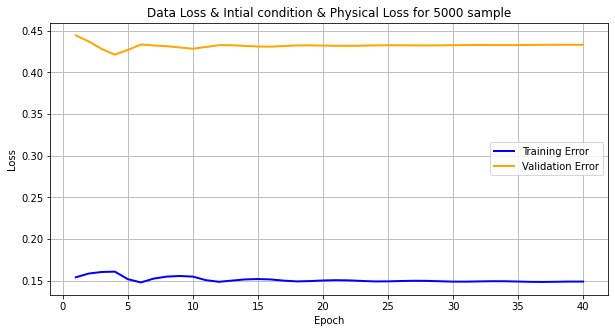

In [38]:
# Training loop
num_epochs = 40
gamma = 0.9999  # Learning rate decay factor

train_errors = []
val_errors = []
for epoch in range(num_epochs):
    sum_train_errors=0
    
    sum_val_errors=0
    for batch in training_data:
        t_current, U0_current, W0_current, K_current, U_true_current, W_true_current = batch

        # Get predictions
        inputs_current = torch.cat([t_current, U0_current, W0_current, K_current], dim=1)
        U_pred, W_pred = MLP_model(inputs_current).split(1, dim=1)

        # Calculate Data loss for the current batch
        loss_D = Data_Loss(U_pred, W_pred,U_true_current, W_true_current)  
        Loss_B = intial_condition(U_true_current, W_true_current,U_pred, W_pred)
        loss_I = Physic_Loss(t_current, U0_current, W0_current, K_current,U_pred, W_pred)

        Total_Loss=loss_D+(2*Loss_B)+loss_I
        sum_train_errors += Total_Loss
        # Backpropagation
        optimizer.zero_grad()
        Total_Loss.backward()
        optimizer.step()
        
    train_errors.append(sum_train_errors)
    
    sum_val_error = 0
    #with torch.no_grad():
    for batch in validation_data:
        t_val, U0_val, W0_val, K_val, U_true_val, W_true_val = batch
            
        # Concatenate inputs for the model
        inputs_val = torch.cat([t_val, U0_val, W0_val, K_val], dim=1)

        # Get predictions
        U_pred_val, W_pred_val = MLP_model(inputs_val).split(1, dim=1)

        # Calculate Data loss for the validation batch
            
        loss_D = Data_Loss(U_pred_val, W_pred_val,U_true_val, W_true_val) 
        Loss_B = intial_condition(U_true_val, W_true_val,U_pred_val, W_pred_val)
        loss_I = Physic_Loss(t_val, U0_val, W0_val, K_val,U_pred_val, W_pred_val)        

        Total_Loss=loss_D+Loss_B+loss_I
        sum_val_errors+=Total_Loss # Store the loss
            
    
    val_errors.append(sum_val_errors)
    

# Plotting the loss against epochs
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1),train_errors, color='blue',label='Training Error', linewidth=2)
plt.plot(range(1, num_epochs + 1),val_errors,color='orange',label='Validation Error', linewidth=2)
plt.title('Data Loss & Intial condition & Physical Loss for 5000 sample')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()  # Add this line to show the legend
plt.grid()
plt.show()

Average Training Loss: 6.03805542 , Average Validation Loss: 17.29010582
Average Test Loss: 0.30845156


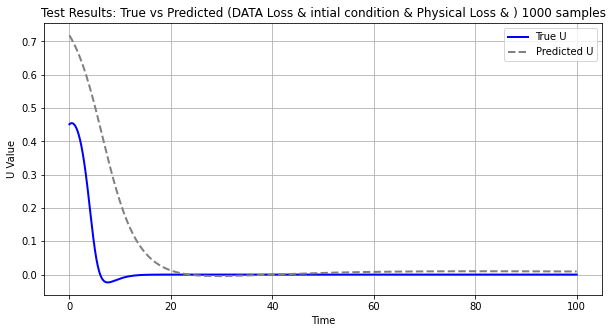

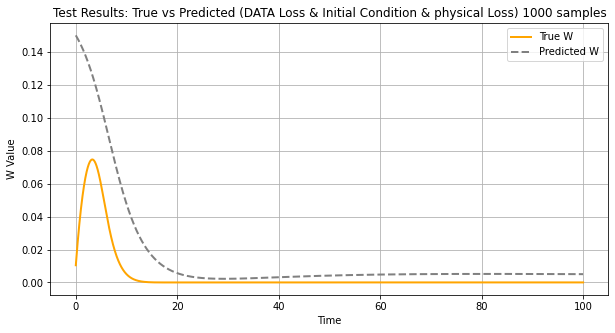

In [39]:
# Plot 
predictions_u = []
predictions_w = []
true_u = []
true_w  = []
Time = []

sum_test_errors=0
for batch in test_data:

    t, U0, W0, K, U_true, W_true = batch

        # Get predictions
    inputs_current = torch.cat([t, U0, W0, K], dim=1)
    U_pred, W_pred = MLP_model(inputs_current).split(1, dim=1)

    # Calculate Data loss for the current batch
    loss_D = Data_Loss(U_pred, W_pred,U_true, W_true)  
    Loss_B = intial_condition(U_true, W_true,U_pred, W_pred)
    loss_I = Physic_Loss(t_val, U0_val, W0_val, K_val,U_pred_val, W_pred_val)        
    Total_Loss=loss_D+Loss_B+loss_I
    sum_test_errors += Total_Loss
    # Store predictions and true values for visualization
    predictions_u.append(U_pred.detach().numpy())
    true_u.append(U_true.detach().numpy())
    predictions_w.append(W_pred.detach().numpy())
    true_w.append(W_true.detach().numpy())
    Time.append(t.detach().numpy())

print(f"Average Training Loss: {sum(train_errors):.8f} , Average Validation Loss: {sum(val_errors):.8f}")
print(f"Average Test Loss: {sum_test_errors:.8f}")



predictions_u=np.concatenate(predictions_u, axis=0).squeeze()
true_u=np.concatenate(true_u, axis=0).squeeze()
predictions_w=np.concatenate(predictions_w, axis=0).squeeze()
true_w=np.concatenate(true_w, axis=0).squeeze()
Time = np.concatenate(Time,axis =0).squeeze()

    # Plotting the loss against epochs
plt.figure(figsize=(10, 5))
plt.plot(Time, true_u, label='True U', color='blue', linewidth=2)
plt.plot(Time, predictions_u, label='Predicted U', color='gray', linestyle='--', linewidth=2)
plt.title('Test Results: True vs Predicted (DATA Loss & intial condition & Physical Loss & ) 1000 samples')
plt.xlabel('Time')
plt.ylabel('U Value')
plt.legend()
plt.grid()

plt.figure(figsize=(10, 5))
plt.plot(Time, true_w, label='True W', color='orange', linewidth=2)
plt.plot(Time, predictions_w, label='Predicted W', color='gray', linestyle='--', linewidth=2)

plt.title('Test Results: True vs Predicted (DATA Loss & Initial Condition & physical Loss) 1000 samples')
plt.xlabel('Time')
plt.ylabel('W Value')
plt.legend()
plt.grid()

plt.show()

In [1]:
# Training loop
num_epochs = 100
gamma = 0.9999  # Learning rate decay factor

train_errors = []
val_errors = []
for epoch in range(num_epochs):
    sum_train_errors=0
    
    sum_val_errors=0
    for batch in training_data:
        t_current, U0_current, W0_current, K_current, U_true_current, W_true_current = batch

        # Get predictions
        inputs_current = torch.cat([t_current, U0_current, W0_current, K_current], dim=1)
        U_pred, W_pred = MLP_model(inputs_current).split(1, dim=1)

        # Calculate Data loss for the current batch
        loss_D = Data_Loss(U_pred, W_pred,U_true_current, W_true_current)  
        Loss_B = intial_condition(U_true_current, W_true_current,U_pred, W_pred)
        loss_I = Physic_Loss(t_current, U0_current, W0_current, K_current,U_pred, W_pred)

        Total_Loss=loss_D+(2*Loss_B)+loss_I
        sum_train_errors += Total_Loss
        # Backpropagation
        optimizer.zero_grad()
        Total_Loss.backward()
        optimizer.step()
        
    train_errors.append(sum_train_errors)
    
    sum_val_error = 0
    #with torch.no_grad():
    for batch in validation_data:
        t_val, U0_val, W0_val, K_val, U_true_val, W_true_val = batch
            
        # Concatenate inputs for the model
        inputs_val = torch.cat([t_val, U0_val, W0_val, K_val], dim=1)

        # Get predictions
        U_pred_val, W_pred_val = MLP_model(inputs_val).split(1, dim=1)

        # Calculate Data loss for the validation batch
            
        loss_D = Data_Loss(U_pred_val, W_pred_val,U_true_val, W_true_val) 
        Loss_B = intial_condition(U_true_val, W_true_val,U_pred_val, W_pred_val)
        loss_I = Physic_Loss(t_val, U0_val, W0_val, K_val,U_pred_val, W_pred_val)        

        Total_Loss=loss_D+Loss_B+loss_I
        sum_val_errors+=Total_Loss # Store the loss
            
    
    val_errors.append(sum_val_errors)
    

# Plotting the loss against epochs
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1),train_errors, color='blue',label='Training Error', linewidth=2)
plt.plot(range(1, num_epochs + 1),val_errors,color='orange',label='Validation Error', linewidth=2)
plt.title('Data Loss & Intial condition & Physical Loss for 5000 sample')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()  # Add this line to show the legend
plt.grid()
plt.show()

NameError: name 'training_data' is not defined

In [ ]:
# Plot 
predictions_u = []
predictions_w = []
true_u = []
true_w  = []
Time = []

sum_test_errors=0
for batch in test_data:

    t, U0, W0, K, U_true, W_true = batch

        # Get predictions
    inputs_current = torch.cat([t, U0, W0, K], dim=1)
    U_pred, W_pred = MLP_model(inputs_current).split(1, dim=1)

    # Calculate Data loss for the current batch
    loss_D = Data_Loss(U_pred, W_pred,U_true, W_true)  
    Loss_B = intial_condition(U_true, W_true,U_pred, W_pred)
    loss_I = Physic_Loss(t_val, U0_val, W0_val, K_val,U_pred_val, W_pred_val)        
    Total_Loss=loss_D+Loss_B+loss_I
    sum_test_errors += Total_Loss
    # Store predictions and true values for visualization
    predictions_u.append(U_pred.detach().numpy())
    true_u.append(U_true.detach().numpy())
    predictions_w.append(W_pred.detach().numpy())
    true_w.append(W_true.detach().numpy())
    Time.append(t.detach().numpy())

print(f"Average Training Loss: {sum(train_errors):.8f} , Average Validation Loss: {sum(val_errors):.8f}")
print(f"Average Test Loss: {sum_test_errors:.8f}")



predictions_u=np.concatenate(predictions_u, axis=0).squeeze()
true_u=np.concatenate(true_u, axis=0).squeeze()
predictions_w=np.concatenate(predictions_w, axis=0).squeeze()
true_w=np.concatenate(true_w, axis=0).squeeze()
Time = np.concatenate(Time,axis =0).squeeze()

    # Plotting the loss against epochs
plt.figure(figsize=(10, 5))
plt.plot(Time, true_u, label='True U', color='blue', linewidth=2)
plt.plot(Time, predictions_u, label='Predicted U', color='gray', linestyle='--', linewidth=2)
plt.title('Test Results: True vs Predicted (DATA Loss & intial condition & Physical Loss & ) 1000 samples')
plt.xlabel('Time')
plt.ylabel('U Value')
plt.legend()
plt.grid()

plt.figure(figsize=(10, 5))
plt.plot(Time, true_w, label='True W', color='orange', linewidth=2)
plt.plot(Time, predictions_w, label='Predicted W', color='gray', linestyle='--', linewidth=2)

plt.title('Test Results: True vs Predicted (DATA Loss & Initial Condition & physical Loss) 1000 samples')
plt.xlabel('Time')
plt.ylabel('W Value')
plt.legend()
plt.grid()

plt.show()


num_epochs = 1000
gamma = 0.9999  # Learning rate decay factor

loss_values = []
x=[]
for epoch in range(num_epochs):

    for batch in training_data:
        t_current, U0_current, W0_current, K_current, U_true_current, W_true_current = batch

        # Get predictions
        inputs_current = torch.cat([t_current, U0_current, W0_current, K_current], dim=1)
        U_pred, W_pred = MLP_model(inputs_current).split(1, dim=1)

        # Calculate physic loss for the current batch
        loss_I = Physic_Loss(t_current, U0_current, W0_current, K_current,U_pred, W_pred)
        loss_values.append(loss_I.detach().numpy())
        x.append(epoch+1)

        # Backpropagation
        optimizer.zero_grad()
        loss_I.backward()
        
        optimizer.step()


    print(f"Epoch [{epoch + 1}/{num_epochs}], Physic Loss: {loss_I:.8f}")

# Plotting the loss against epochs
plt.figure(figsize=(10, 5))
plt.plot(x, loss_values, color='blue', linewidth=2)
plt.title('Physic Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.show()